In [1]:
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.data.shape)

(1797, 64)


In [64]:
from sklearn.model_selection import train_test_split
test_size_ratios: list[float] = [i/10 for i in range(1,10)]
print(test_size_ratios)

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]


In [65]:
from sklearn.linear_model import LogisticRegression
import numpy as np

In [66]:
accuracys: float = []
for r in test_size_ratios:
    X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, train_size=r, test_size=1-r, random_state=0)
    clf = LogisticRegression(random_state=0, max_iter=10000).fit(X_train, y_train)
    total = X_test.shape[0]
    correct = np.sum(clf.predict(X_test) == y_test)
    acc = correct / total
    print(f"{r=}, got accuracy: {acc}. {total=}, {correct=}")
    accuracys.append(acc)


r=0.1, got accuracy: 0.9400494437577256. total=1618, correct=1521
r=0.2, got accuracy: 0.9492350486787204. total=1438, correct=1365
r=0.3, got accuracy: 0.9618441971383148. total=1258, correct=1210
r=0.4, got accuracy: 0.963855421686747. total=1079, correct=1040
r=0.5, got accuracy: 0.9543937708565072. total=899, correct=858
r=0.6, got accuracy: 0.9582753824756607. total=719, correct=689
r=0.7, got accuracy: 0.9555555555555556. total=540, correct=516
r=0.8, got accuracy: 0.9583333333333334. total=360, correct=345
r=0.9, got accuracy: 0.9555555555555556. total=180, correct=172


In [67]:
import matplotlib.pyplot as plt

<function matplotlib.pyplot.show(close=None, block=None)>

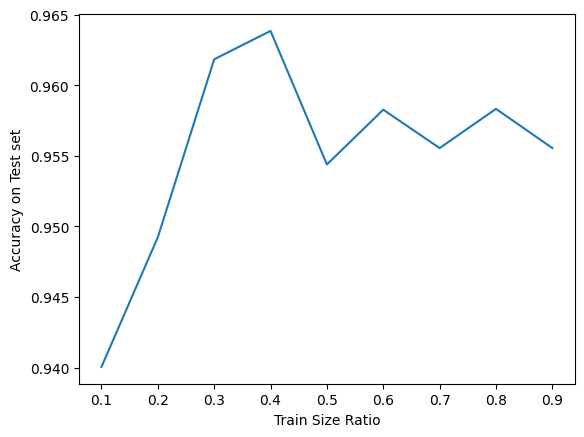

In [68]:
plt.plot(test_size_ratios, accuracys)
plt.xlabel("Train Size Ratio")
plt.ylabel("Accuracy on Test set")
plt.show

## Unbalanced

In [50]:
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, train_size=1000, test_size=digits.data.shape[0]-1000, random_state=0)

(1078, 64)


1078